In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [2]:
!kaggle datasets download -d swoyam2609/fresh-and-stale-classification

Dataset URL: https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification
License(s): Community Data License Agreement - Permissive - Version 1.0
fresh-and-stale-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
import torch
from torch import nn,optim
!pip install torchinfo
from torchinfo import summary
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import zipfile
import numpy as np
import torch.nn.functional as F

In [5]:
# 2️⃣ Extract Dataset
zip_ref = zipfile.ZipFile('/content/fresh-and-stale-classification.zip','r')
zip_ref.extractall('/content/fresh-and-stale-classification')
zip_ref.close()


In [6]:
# 3️⃣ Check dataset path
dataset_dir = Path("/content/fresh-and-stale-classification")
if dataset_dir.is_dir():
    print(f"{dataset_dir} directory exists.")
else:
    print("Dataset directory not found.")


/content/fresh-and-stale-classification directory exists.


In [7]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='/content/fresh-and-stale-classification/dataset/Train', transform=transform)
val_dataset = ImageFolder(root='/content/fresh-and-stale-classification/dataset/Test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, embed_dim=96, patch_size=4):
        super(PatchEmbedding, self).__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, N, C)
        return x, (H, W)

In [9]:

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.0):
        super(MLP, self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [10]:

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(0.0)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (1.0 / np.sqrt(k.size(-1)))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        return x


In [11]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4.0):
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size=window_size, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio))

    def forward(self, x, H, W):
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = self.window_partition(shifted_x)  # (num_windows*B, window_size, window_size, C)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        # Window attention
        attn_windows = self.attn(x_windows)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = self.window_reverse(attn_windows, H, W)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + x
        x = x + self.mlp(self.norm2(x))
        return x

    def window_partition(self, x):
        B, H, W, C = x.shape
        x = x.view(B, H // self.window_size, self.window_size, W // self.window_size, self.window_size, C)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, self.window_size, self.window_size, C)
        return windows

    def window_reverse(self, windows, H, W):
        B = int(windows.shape[0] / (H * W / self.window_size / self.window_size))
        x = windows.view(B, H // self.window_size, W // self.window_size, self.window_size, self.window_size, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
        return x


In [12]:
class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim):
        super(PatchMerging, self).__init__()
        self.input_resolution = input_resolution
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(4 * dim)

    def forward(self, x, H, W):
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1)  # (B, H/2, W/2, 4*C)
        x = x.view(B, -1, 4 * C)
        x = self.norm(x)
        x = self.reduction(x)
        return x


In [13]:
class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_channels=3, num_classes=2, embed_dim=96,
                 depths=[2, 2], num_heads=[3, 6], window_size=7):
        super(SwinTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim

        self.patch_embed = PatchEmbedding(in_channels, embed_dim, patch_size)
        self.pos_drop = nn.Dropout(0.0)

        # Stages
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = nn.ModuleList()
            for i_block in range(depths[i_layer]):
                layer.append(SwinTransformerBlock(
                    dim=embed_dim * (2 ** i_layer),
                    input_resolution=(img_size // (2 ** (i_layer + 2)), img_size // (2 ** (i_layer + 2))),
                    num_heads=num_heads[i_layer],
                    window_size=window_size,
                    shift_size=0 if (i_block % 2 == 0) else window_size // 2
                ))
            self.layers.append(layer)
            if (i_layer < self.num_layers - 1):
                self.layers.append(PatchMerging(
                    input_resolution=(img_size // (2 ** (i_layer + 2)), img_size // (2 ** (i_layer + 2))),
                    dim=embed_dim * (2 ** i_layer)
                ))

        self.norm = nn.LayerNorm(embed_dim * (2 ** (self.num_layers - 1)))
        self.head = nn.Linear(embed_dim * (2 ** (self.num_layers - 1)), num_classes)

    def forward(self, x):
        x, (H, W) = self.patch_embed(x)
        x = self.pos_drop(x)

        for layer in self.layers:
            if isinstance(layer, nn.ModuleList):
                for block in layer:
                    x = block(x, H, W)
            else:
                x = layer(x, H, W)
                H, W = H // 2, W // 2

        x = self.norm(x)
        x = x.mean(1)
        x = self.head(x)
        return x

In [16]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinTransformer(num_classes=2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Accuracy: {100 * correct/total:.2f}%')
        evaluate_model(model, val_loader)

In [18]:
# Evaluation
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation Accuracy: {100 * correct/total:.2f}%')

In [24]:
num_classes = len(train_dataset.classes)  # Get the number of classes from the dataset
model = SwinTransformer(num_classes=num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

Epoch [1/3], Loss: 0.9441, Accuracy: 69.29%
Validation Accuracy: 24.16%
Epoch [2/3], Loss: 0.4129, Accuracy: 85.30%
Validation Accuracy: 20.24%
Epoch [3/3], Loss: 0.2958, Accuracy: 89.31%
Validation Accuracy: 24.06%


In [25]:
# Single image prediction
def predict_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    class_names = train_dataset.classes
    return class_names[predicted.item()]


In [29]:
# Predict
!pip install Pillow
from PIL import Image
image_path = '/content/a2.jpg'
prediction = predict_image(image_path, model, transform)
print(f'Prediction: {prediction}')

Prediction: rottenapples


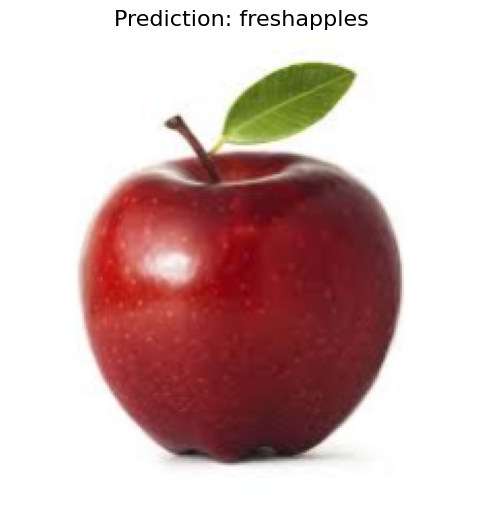

Prediction: freshapples


In [32]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Predict and display image
def predict_and_show(image_path, model, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        _, predicted = torch.max(output, 1)

    class_names = train_dataset.classes
    prediction = class_names[predicted.item()]

    # Display image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(TF.to_pil_image(transformed_image.cpu().squeeze()))
    plt.title(f'Prediction: {prediction}', fontsize=16)
    plt.axis('off')
    plt.show()

    return prediction

# Example usage
image_path = '/content/a1.jpeg'
prediction = predict_and_show(image_path, model, transform)
print(f'Prediction: {prediction}')
